# K-means for Image Processing

One cool application for K-means(other than the obvious use in clustering data points) is to process images. The first technique we'll explore is image segmentation, where the K-means algorithm will give us however many centers we want and we'll set image pixel values equal to their respective means. 

In [282]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

It makes sense to start by copying our already written K-means implementation from the other notebook.

In [78]:
def calcerror(data, rnk, centers):
    err = 0.0
    for i in np.arange(len(centers)):
        err = err + np.sum((np.linalg.norm(data[np.where(rnk==i)[0], :] - centers[i], axis=1))**2, axis=0)
    return err

def kmeans(data, k):
    num = 5  
    error = -1
    fincenters = None
    finrnk = None
    
    # run 5 models and only update the final centers and labels if the error is lower than the previous
    for l in np.arange(num):
        # step 1
        centers = data[random.sample(range(data.shape[0]), k), :]
        newcenters = np.zeros(centers.shape)
        abort = 0    
        # cap the algorithm at 10 iterations, any more and it will just use up computational time
        for j in np.arange(10):
            # step 2
            temp = np.empty([len(centers), len(data)])
            for i in np.arange(len(centers)):
                temp[i] = (np.linalg.norm(data - centers[i], axis=1))**2
            dist = pd.DataFrame(temp.T)
            rnk = np.array([dist.idxmin(axis=1)]).T

            if(abort):
                break
            # step 3
            for i in np.arange(len(centers)):
                newcenters[i] = np.sum(data[np.where(rnk==i)[0], :], axis=0) / len(np.where(rnk==i)[0])

            if(np.array_equal(centers, newcenters)):
                abort = 1
            centers = newcenters
            
        if(error == -1):
            error = calcerror(data, rnk, centers)
            fincenters = centers
            finrnk = rnk
        elif(error > calcerror(data, rnk, centers)):
            fincenters = centers
            finrnk = rnk
            error = calcerror(data, rnk, centers)
            
    return(fincenters, finrnk)

We can now load our image and format the pixel values. For the sake of simplicity(and to not bite off more than we can chew), let's start with a black and white image before moving onto color images.

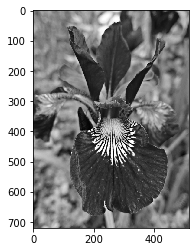

In [114]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

image = rgb2gray(plt.imread('iris.png'))
plt.imshow(image, cmap='gray')

As briefly mentioned previously, we want to first compute the cluster centers using K-means and then assign pixel values to their respective means. As for dealing with the image data, we first flatten the matrix we get from imread to get a vector of pixel values. After processing we have to reconstruct the image matrix before outputting it.

In [138]:
def imgseg(img, k):
    col = img.shape[0]
    row = img.shape[1]

    flatimage = np.reshape(img, (-1,1))
    centers, labels = kmeans(flatimage, k)

    temp = pd.DataFrame(np.hstack((flatimage, labels)), columns=['img', 'label'])
    for i in np.arange(len(np.unique(labels))):
        temp['img'].loc[temp['label'] == i] = float(centers[i])

    newimg = np.array(temp['img'])

    fig, ax = plt.subplots(1, 2, figsize=(10,8))
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(np.reshape(newimg, (col, -1)), cmap='gray')

Wall time: 8.54 s


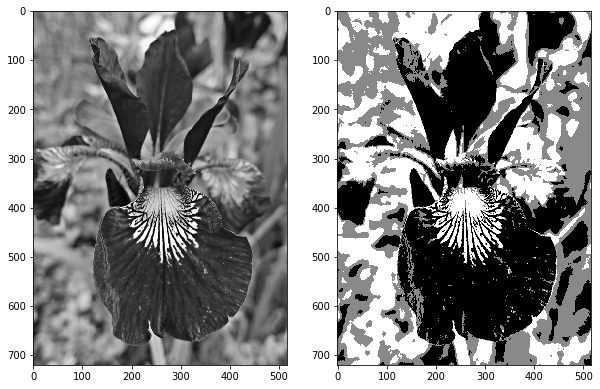

In [290]:
%%time
imgseg(rgb2gray(plt.imread('iris.png')), 3)

Wall time: 8.93 s


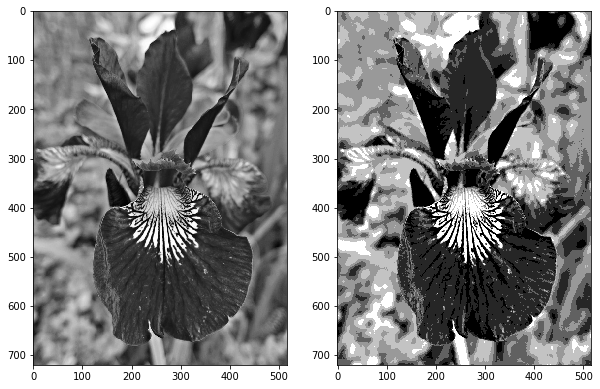

In [292]:
%%time
imgseg(rgb2gray(plt.imread('iris.png')), 6)

As expected, the more clusters there are the more complex the processed image looks. What is surprising is the very small increase in time the algorithm took to run when we increased K from 3 to 6.

Now we can move on to K-means-ing our color image. This works basically the same as the black and white except in 3D. Formatting is a bit trickier because of that, but it's pretty similar otherwise.

In [278]:
def rgbaimgseg(img, k, re = False):
    # to store altered rgb
    newimg = np.zeros(img.shape)
    
    # extract and flatten rgb
    c = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3]
    r = np.reshape(c[0], (-1, 1))
    g = np.reshape(c[1], (-1, 1))
    b = np.reshape(c[2], (-1, 1))
    col = c[0].shape[0]
    row = c[0].shape[1]

    rgb = np.hstack((r, g, b))

    centers, labels = kmeans(rgb, k)
    #print(labels)

    temp = pd.DataFrame(np.hstack((rgb, labels)), columns=['r', 'g', 'b', 'label'])
    #print(temp)
    for i in np.arange(len(np.unique(labels))):
        temp['r'].loc[temp['label'] == i] = centers[i, 0]
        temp['g'].loc[temp['label'] == i] = centers[i, 1]
        temp['b'].loc[temp['label'] == i] = centers[i, 2]

    newimg[:, :, 0] = np.reshape(np.array(temp['r']), (col, -1))
    newimg[:, :, 1] = np.reshape(np.array(temp['g']), (col, -1))
    newimg[:, :, 2] = np.reshape(np.array(temp['b']), (col, -1))     
    newimg[:, :, 3] = c[3]
    
    if(re):
        return(newimg)
    else:
        fig, ax = plt.subplots(1, 2, figsize=(10,8))
        ax[0].imshow(img)
        ax[1].imshow(newimg)

Wall time: 8.82 s


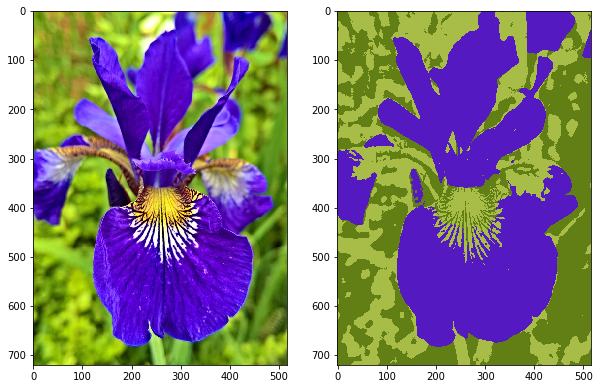

In [286]:
%%time
rgbaimgseg(plt.imread('iris.png'), 3)

Wall time: 10.1 s


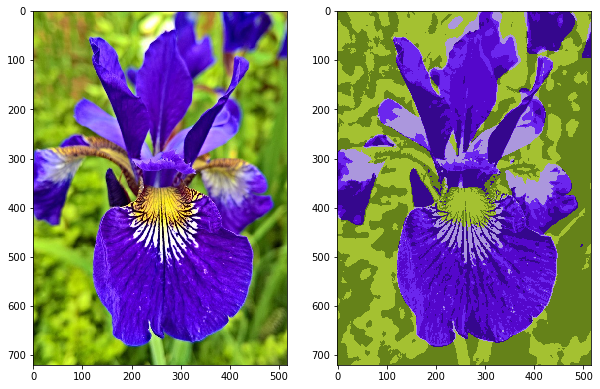

In [289]:
%%time
rgbaimgseg(plt.imread('iris.png'), 6)

The computational time for the algorithm to converge was barely fazed by our moving from grayscale to rgb, which tripled the dimension. This makes sense, as increasing the dimension only affects the calculation of the $l_{2}$ norm, which has a $O(n)$ time complexity. We can expect to see the algorithm slow down when the dimension increases much more, but going from 1 to 3 shouldn't make much of a difference.

We can also compare these to a larger image. Our current one is 516x720 pixels, which totals around 30k pixels. Let's see how our algorithm performs on a larger image with 1500x857 pixels, or about 1.2 million total.

Wall time: 31.4 s


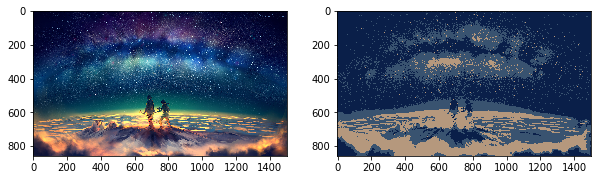

In [293]:
%%time
img = plt.imread('bigimg.png')
rgbaimgseg(img, 3)

Wall time: 34.8 s


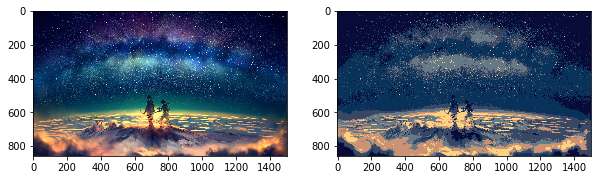

In [294]:
%%time
img = plt.imread('bigimg.png')
rgbaimgseg(img, 6)

We can also perform K-means on each R, G, and B vector separately before recombining. This leads to the true number of clusters 
being larger than our specified K, but it's kinda cool nonetheless.

In [280]:
def eachcolorseg(img, k, re = False):
    newimg = np.zeros(img.shape)
    c = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3]
    col = c[0].shape[0]
    row = c[0].shape[1]

    for j in np.arange(3):
        flat = np.reshape(c[j], (-1,1))
        centers, labels = kmeans(flat, k)

        temp = pd.DataFrame(np.hstack((flat, labels)), columns=['img', 'label'])
        for i in np.arange(len(np.unique(labels))):
            temp['img'].loc[temp['label'] == i] = float(centers[i])

        new = np.reshape(np.array(temp['img']), (col, -1))
        newimg[:, :, j] = new
        
    if(re):
        newimg[:, :, 3] = c[3]
    else:
        fig, ax = plt.subplots(1, 2, figsize=(10,8))
        ax[0].imshow(img)
        ax[1].imshow(newimg)

C:\Users\Edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


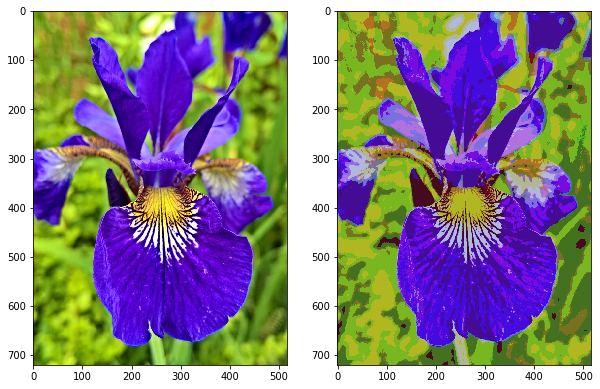

In [254]:
eachcolorseg(plt.imread('iris.png'), 3)

C:\Users\Edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


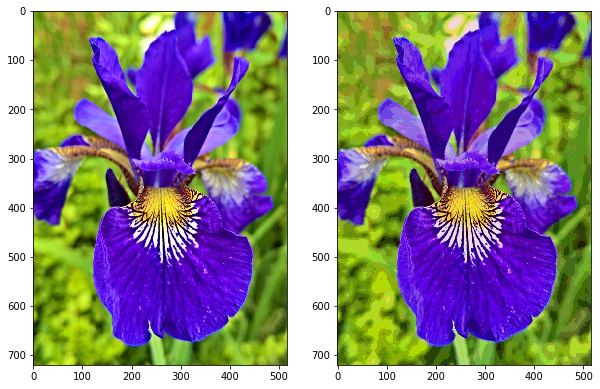

In [162]:
eachcolorseg(plt.imread('iris.png'), 7)